# Project 4 DDPM with DIP prior


## Import library

In [4]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd

from torch.utils.data import DataLoader
from tqdm import tqdm
from skimage.color import rgb2lab, deltaE_ciede2000
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from torchvision import datasets
from torchvision.datasets import STL10

## 1.DDPM only

### A. Config

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_sub_blocks = 10
input_channels = 3  # For RGB images
num_epochs = 40

noise_levels = [0.01 * np.exp(-0.05 * i) for i in range(1000)] #exponential decay

#noise_levels = [0.01 * (1 - i / 1000) for i in range(1000)] #linear decay

#random.seed(42)
#noise_levels = [0.01 * random.uniform(0.5, 1.5) for _ in range(1000)] #random



### B. Prepare dataset(STL-10)

In [6]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet's mean and std
])

training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)


Files already downloaded and verified


### C. Define DDPM

#### Forward process
在 DDPM 中，forward process 是將原始圖像逐漸添加隨機噪聲，最終生成純噪聲的過程。這個過程可以分為以下幾個步驟：

1. **原始圖像**：開始於一張清晰的原始圖像，例如一隻貓的照片。
2. **n次添加噪聲**：將一定程度的隨機噪聲添加到圖像中，使得圖像變得略微模糊。
3. **最終結果**：經過多次添加噪聲後，圖像最終變成純噪聲。

在這個過程中，每一步添加的噪聲都是根據一定的概率分布進行的，這樣可以保證過程的可逆性。在訓練階段，模型學習如何從噪聲中逐漸去除噪聲，從而恢復原始圖像。

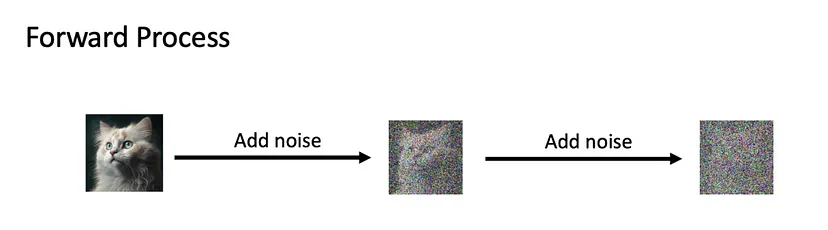

```python
class SubBlock(nn.Module):
        '
        '
        '
    def add_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_time_list[t]
        return self.add_noise(x, sigma_t) - self.network(x)

class DDPM(nn.Module):  
        '
        '
        '      
    def forward(self, x, t):
        return self.forward_process(x, t)
    
    def forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x    


#### Reverse process
在 DDPM 中，reverse process 是從純噪聲逐漸去除隨機噪聲，最終恢復到原始圖像的過程。這個過程可以分為以下幾個步驟：

1. **純噪聲圖像**：開始於一張完全隨機的噪聲圖像。
2. **n次去除噪聲**：模型根據當前的噪聲水平預測並去除部分噪聲，使得圖像略微變得清晰。
3. **最終結果**：經過多次去除噪聲後，圖像逐漸恢復到接近原始的清晰圖像。

在這個過程中，每一步去除的噪聲都是通過模型預測的。模型在訓練階段學習如何從噪聲中逐步恢復原始圖像。

這個過程有助於模型學習如何從噪聲中重建原始圖像，最終可以在生成模型中應用。


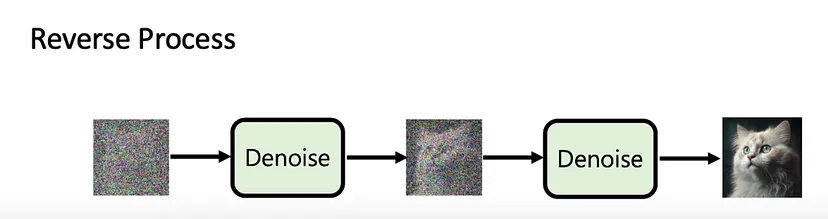

```python
class DDPM(nn.Module):
    def reverse_process(self, x, num_steps=1000):
        for t in tqdm(reversed(range(num_steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

#### Model Spec  
loss function: MSE  
optimizer: AdamW  



In [7]:
class SubBlock(nn.Module):
    def __init__(self, input_channels, noise_levels):
        super(SubBlock, self).__init__()
        self.noise_levels = nn.Parameter(torch.tensor(noise_levels), requires_grad=False)
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, input_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(input_channels),
            
            #n.Conv2d(input_channels, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=5, padding=2),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Conv2d(128, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, input_channels, kernel_size=5, padding=2),
            #nn.BatchNorm2d(input_channels)
        )

    def apply_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_levels[t]
        return self.apply_noise(x, sigma_t) - self.network(x)     

In [8]:
class DDPM(nn.Module):
    def __init__(self, num_sub_blocks, input_channels, noise_levels):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_sub_blocks):
            self.blocks.append(SubBlock(input_channels, noise_levels))

    def apply_forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x
    
    def apply_reverse_process(self, x, steps=1000):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

    '''
    def apply_reverse_process(self, x, steps):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            t_step = torch.full((x.size(0),), t, dtype=torch.long, device=x.device)
            for block in self.blocks:
                x = block(x, t_step)
        return x
    '''

    def forward(self, x, t):
        return self.apply_forward_process(x, t)
        
def restored_image_func(model, input_image, num_iterations):
    model.eval()
    with torch.no_grad():
        x = input_image.unsqueeze(0).to(device)
        for _ in range(num_iterations):
            random_t = torch.randint(0, len(noise_levels), (1,)).item()
            x = model(x, t=random_t)
        return x.squeeze(0).cpu()

In [9]:
model = DDPM(num_sub_blocks, input_channels, noise_levels).to(device)
loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### D. Training and Plot Loss

Epoch 1/40: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s]


Epoch [1/40], Average Loss: 0.250839 



Epoch 2/40: 100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


Epoch [2/40], Average Loss: 0.021999 



Epoch 3/40: 100%|██████████| 157/157 [00:04<00:00, 34.04it/s]


Epoch [3/40], Average Loss: 0.013127 



Epoch 4/40: 100%|██████████| 157/157 [00:04<00:00, 34.23it/s]


Epoch [4/40], Average Loss: 0.009805 



Epoch 5/40: 100%|██████████| 157/157 [00:04<00:00, 34.50it/s]


Epoch [5/40], Average Loss: 0.007286 



Epoch 6/40: 100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


Epoch [6/40], Average Loss: 0.006775 



Epoch 7/40: 100%|██████████| 157/157 [00:04<00:00, 34.56it/s]


Epoch [7/40], Average Loss: 0.006271 



Epoch 8/40: 100%|██████████| 157/157 [00:04<00:00, 34.07it/s]


Epoch [8/40], Average Loss: 0.004824 



Epoch 9/40: 100%|██████████| 157/157 [00:04<00:00, 34.21it/s]


Epoch [9/40], Average Loss: 0.004534 



Epoch 10/40: 100%|██████████| 157/157 [00:04<00:00, 34.45it/s]


Epoch [10/40], Average Loss: 0.004235 



Epoch 11/40: 100%|██████████| 157/157 [00:04<00:00, 33.88it/s]


Epoch [11/40], Average Loss: 0.003999 



Epoch 12/40: 100%|██████████| 157/157 [00:04<00:00, 34.14it/s]


Epoch [12/40], Average Loss: 0.004026 



Epoch 13/40: 100%|██████████| 157/157 [00:04<00:00, 34.17it/s]


Epoch [13/40], Average Loss: 0.003703 



Epoch 14/40: 100%|██████████| 157/157 [00:04<00:00, 34.40it/s]


Epoch [14/40], Average Loss: 0.003190 



Epoch 15/40: 100%|██████████| 157/157 [00:04<00:00, 34.15it/s]


Epoch [15/40], Average Loss: 0.002552 



Epoch 16/40: 100%|██████████| 157/157 [00:04<00:00, 31.87it/s]


Epoch [16/40], Average Loss: 0.002576 



Epoch 17/40: 100%|██████████| 157/157 [00:04<00:00, 33.62it/s]


Epoch [17/40], Average Loss: 0.002302 



Epoch 18/40: 100%|██████████| 157/157 [00:04<00:00, 33.92it/s]


Epoch [18/40], Average Loss: 0.001807 



Epoch 19/40: 100%|██████████| 157/157 [00:04<00:00, 34.11it/s]


Epoch [19/40], Average Loss: 0.001576 



Epoch 20/40: 100%|██████████| 157/157 [00:04<00:00, 34.69it/s]


Epoch [20/40], Average Loss: 0.001532 



Epoch 21/40: 100%|██████████| 157/157 [00:04<00:00, 34.43it/s]


Epoch [21/40], Average Loss: 0.001612 



Epoch 22/40: 100%|██████████| 157/157 [00:04<00:00, 34.11it/s]


Epoch [22/40], Average Loss: 0.001148 



Epoch 23/40: 100%|██████████| 157/157 [00:04<00:00, 33.65it/s]


Epoch [23/40], Average Loss: 0.001291 



Epoch 24/40: 100%|██████████| 157/157 [00:04<00:00, 34.37it/s]


Epoch [24/40], Average Loss: 0.001060 



Epoch 25/40: 100%|██████████| 157/157 [00:04<00:00, 34.60it/s]


Epoch [25/40], Average Loss: 0.000917 



Epoch 26/40: 100%|██████████| 157/157 [00:04<00:00, 34.38it/s]


Epoch [26/40], Average Loss: 0.000921 



Epoch 27/40: 100%|██████████| 157/157 [00:04<00:00, 34.39it/s]


Epoch [27/40], Average Loss: 0.000883 



Epoch 28/40: 100%|██████████| 157/157 [00:04<00:00, 34.43it/s]


Epoch [28/40], Average Loss: 0.000742 



Epoch 29/40: 100%|██████████| 157/157 [00:04<00:00, 34.75it/s]


Epoch [29/40], Average Loss: 0.000706 



Epoch 30/40: 100%|██████████| 157/157 [00:04<00:00, 34.70it/s]


Epoch [30/40], Average Loss: 0.000683 



Epoch 31/40: 100%|██████████| 157/157 [00:04<00:00, 34.70it/s]


Epoch [31/40], Average Loss: 0.000628 



Epoch 32/40: 100%|██████████| 157/157 [00:04<00:00, 33.80it/s]


Epoch [32/40], Average Loss: 0.000648 



Epoch 33/40: 100%|██████████| 157/157 [00:04<00:00, 34.31it/s]


Epoch [33/40], Average Loss: 0.000613 



Epoch 34/40: 100%|██████████| 157/157 [00:04<00:00, 34.56it/s]


Epoch [34/40], Average Loss: 0.000633 



Epoch 35/40: 100%|██████████| 157/157 [00:04<00:00, 34.65it/s]


Epoch [35/40], Average Loss: 0.000589 



Epoch 36/40: 100%|██████████| 157/157 [00:04<00:00, 34.83it/s]


Epoch [36/40], Average Loss: 0.000546 



Epoch 37/40: 100%|██████████| 157/157 [00:04<00:00, 34.57it/s]


Epoch [37/40], Average Loss: 0.000872 



Epoch 38/40: 100%|██████████| 157/157 [00:04<00:00, 34.67it/s]


Epoch [38/40], Average Loss: 0.000627 



Epoch 39/40: 100%|██████████| 157/157 [00:04<00:00, 34.54it/s]


Epoch [39/40], Average Loss: 0.000484 



Epoch 40/40: 100%|██████████| 157/157 [00:04<00:00, 34.55it/s]


Epoch [40/40], Average Loss: 0.000539 



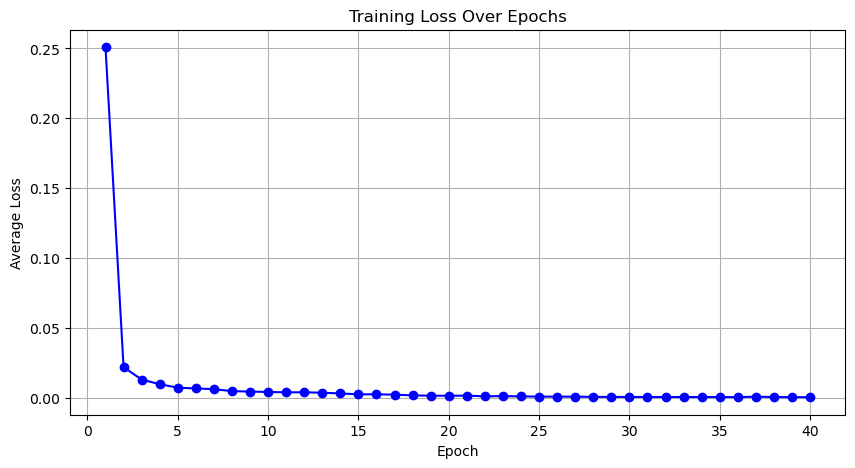

In [10]:
losses = []
model.train()

for epoch_num in range(num_epochs):
    total_loss = 0.0
    for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1}/{num_epochs}"):
        input_data = batch_data[0].to(device)
        optimizer.zero_grad()
        time_step = torch.randint(0, len(noise_levels), (1,)).item()
        predicted_output = model(input_data, t=time_step)
        loss_value = loss_function(predicted_output, input_data)
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value.item()
    
    average_loss = total_loss / len(train_dataloader)
    losses.append(average_loss)
    print(f"Epoch [{epoch_num+1}/{num_epochs}], Average Loss: {average_loss:.6f} \n")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

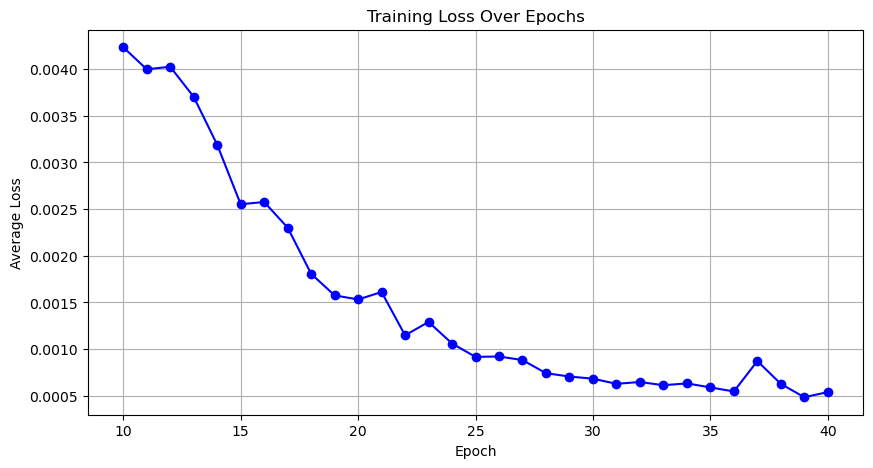

In [11]:
start_epoch = 10
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs + 1), losses[start_epoch - 1:], marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

#### E. Evaluation

在這部分，我們將評估模型在多個測試圖像上的性能。我們會使用去噪後的圖像來計算以下指標。

##### PSNR（Peak Signal-to-Noise Ratio）
PSNR 是一種基於像素誤差的圖像質量評價指標。它通過計算去噪圖像和原始圖像之間的均方誤差（MSE）來衡量圖像的質量。PSNR 的單位是分貝（dB），數值越大表示圖像質量越好。

##### SSIM（Structural Similarity Index）
SSIM 是一種更接近人類視覺系統的圖像質量評價指標。它通過比較兩幅圖像的亮度、對比度和結構來衡量圖像的相似性。SSIM 的取值範圍在[-1, 1]之間，數值越接近1表示圖像質量越好。

##### MSE（Mean Squared Error）
MSE 是一種基於像素誤差的圖像質量評估指標。它通過計算去噪圖像和原始圖像之間每個像素的差值平方和的平均值來衡量圖像的質量。MSE 值越小，表示去噪圖像與原始圖像之間的差異越小，圖像質量越好。

##### MAE（Mean Absolute Error）
MAE 是一種計算去噪圖像和原始圖像之間每個像素絕對差值的平均值的圖像質量評估指標。MAE 值越小，表示去噪圖像與原始圖像之間的差異越小，圖像質量越好。

##### Delta E（ΔE）
Delta E 是一種用於評估兩種顏色之間差異的指標。它基於 CIE Lab* 色彩空間，通過計算去噪圖像和原始圖像之間顏色差異來衡量圖像的質量。Delta E 值越小，表示去噪圖像與原始圖像之間的顏色差異越小，圖像質量越好。


Image 1 - PSNR: 35.7304, SSIM: 0.9840, MSE: 0.0003, MAE: 0.0131, Delta E: 3.7065


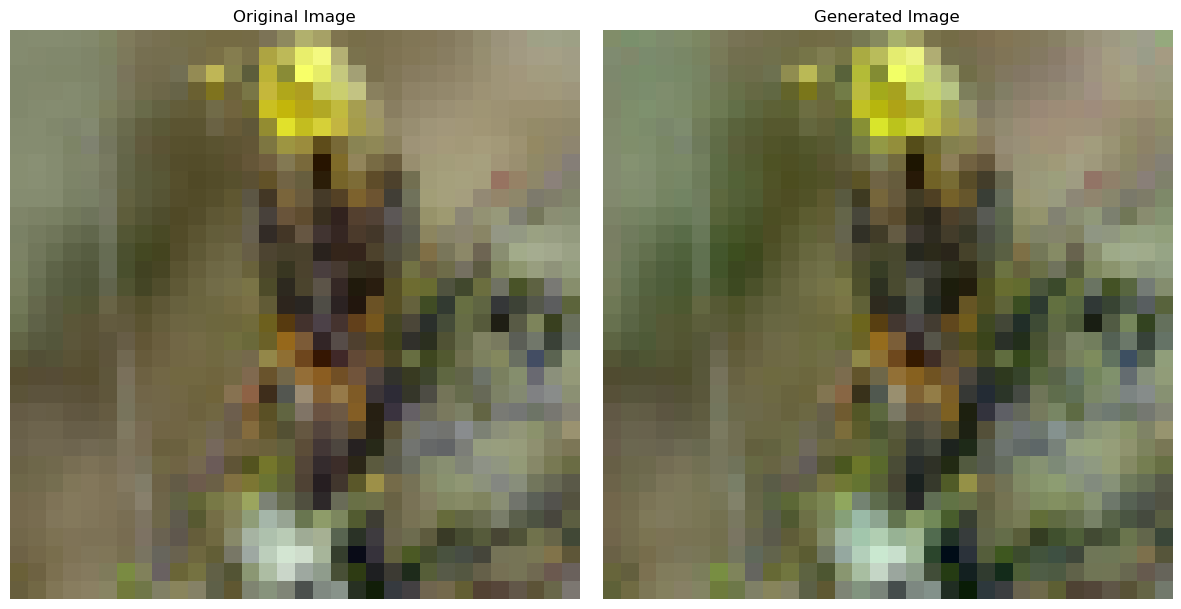

Image 2 - PSNR: 28.7780, SSIM: 0.9842, MSE: 0.0013, MAE: 0.0337, Delta E: 4.3880


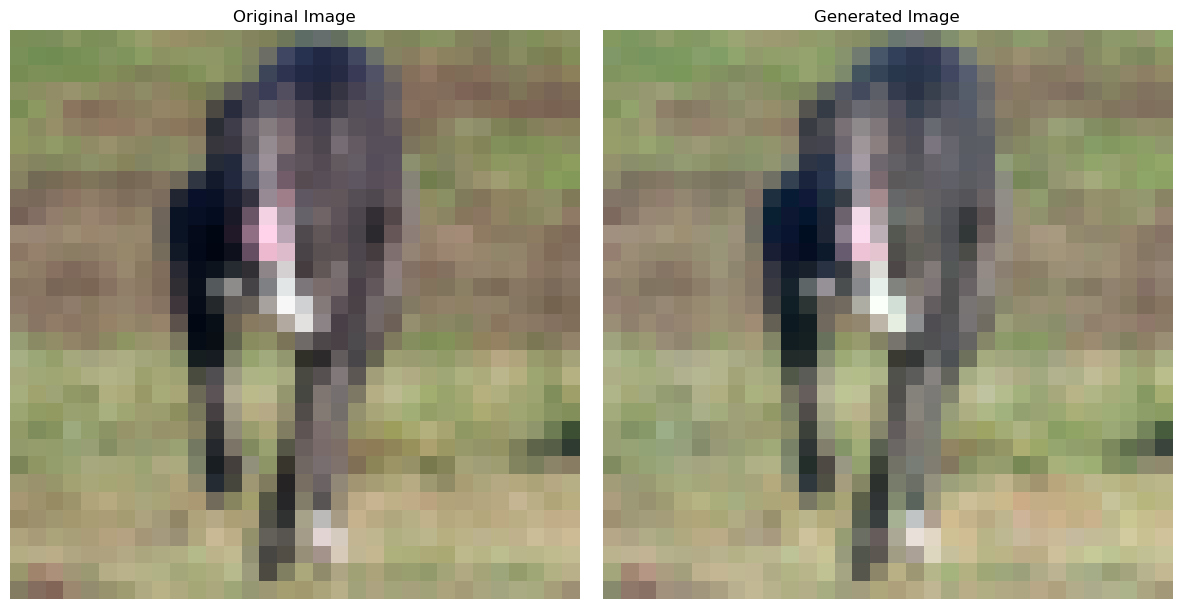

Image 3 - PSNR: 27.6670, SSIM: 0.9723, MSE: 0.0017, MAE: 0.0350, Delta E: 4.5423


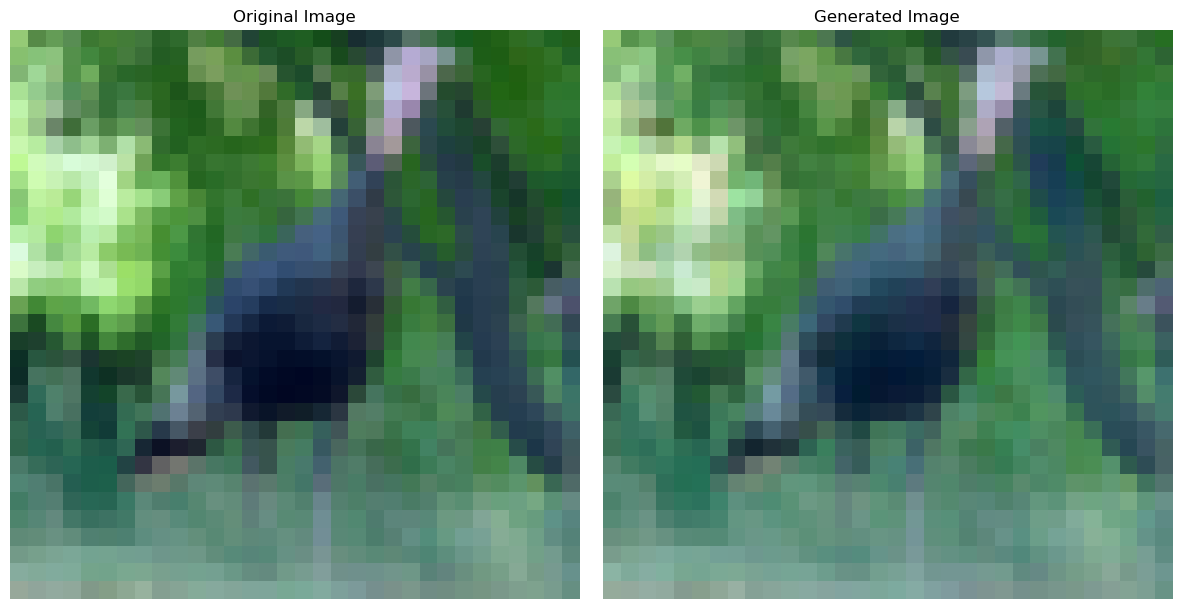

Image 4 - PSNR: 26.7933, SSIM: 0.8792, MSE: 0.0021, MAE: 0.0364, Delta E: 7.8291


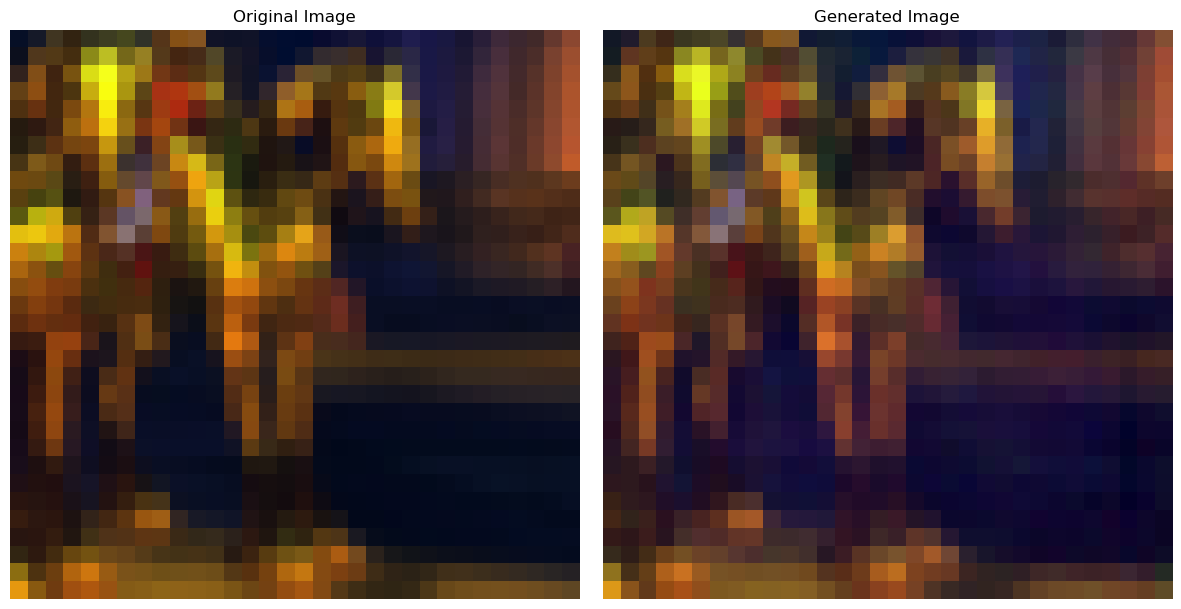

Image 5 - PSNR: 27.7480, SSIM: 0.9709, MSE: 0.0017, MAE: 0.0340, Delta E: 5.1482


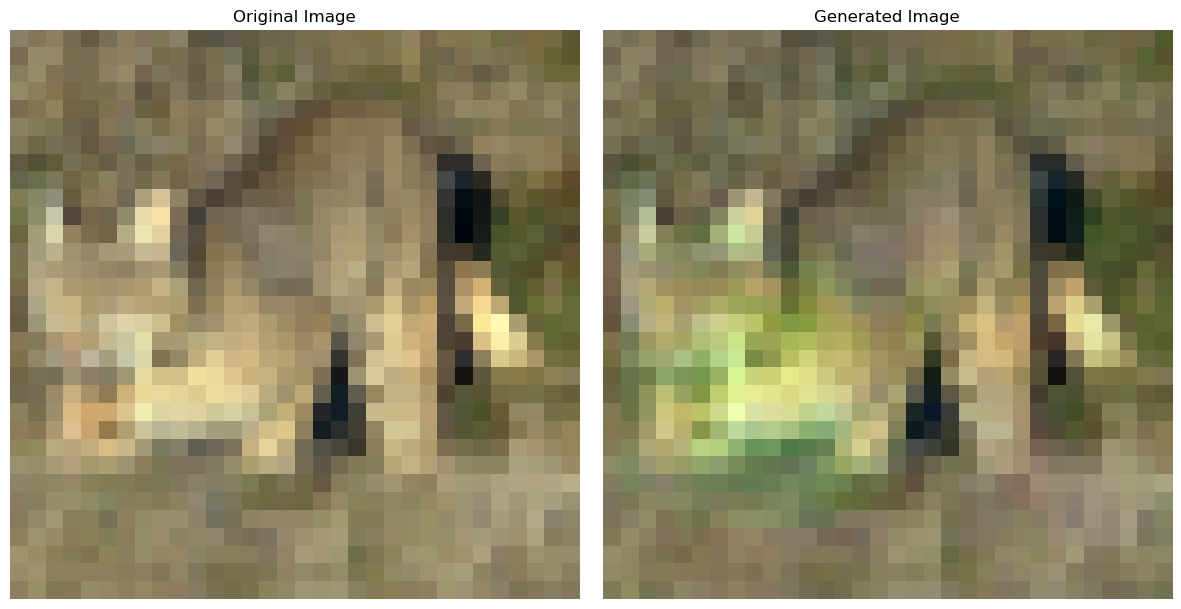

|    |   Image |    PSNR |     SSIM |         MSE |       MAE |   Delta E |
|---:|--------:|--------:|---------:|------------:|----------:|----------:|
|  0 |       1 | 35.7304 | 0.983977 | 0.000267279 | 0.0131437 |   3.70649 |
|  1 |       2 | 28.778  | 0.984231 | 0.00132495  | 0.0336992 |   4.38799 |
|  2 |       3 | 27.667  | 0.972272 | 0.0017112   | 0.0349826 |   4.54233 |
|  3 |       4 | 26.7933 | 0.879174 | 0.00209252  | 0.0363661 |   7.82913 |
|  4 |       5 | 27.748  | 0.970887 | 0.00167956  | 0.0339818 |   5.1482  |


Average PSNR: 29.3433
Average SSIM: 0.9581
Average MSE: 0.0014
Average MAE: 0.0304
Average Delta E: 5.1228


In [12]:
num_images = 5
psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []
results = []

def display_images(original_img, generated_img):
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(121)
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2 = plt.subplot(122)
    ax2.imshow(generated_img)
    ax2.set_title('Generated Image')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(num_images):
    test_image, _ = training_set[i]
    restored_image = restored_image_func(model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    original_image = test_image.cpu().permute(1, 2, 0).numpy()
    generated_image = restored_image.cpu().permute(1, 2, 0).numpy()

    psnr_value = psnr(original_image, generated_image, data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(original_image, generated_image, multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(original_image, generated_image)
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(original_image)
    restored_image_lab = rgb2lab(generated_image)
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

    print(f"Image {i+1} - PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, MSE: {mse_value:.4f}, MAE: {mae_value:.4f}, Delta E: {deltaE_value:.4f}")

    display_images(original_image, generated_image)
    results.append({
        "Image": i + 1,
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "MSE": mse_value,
        "MAE": mae_value,
        "Delta E": deltaE_value
    })

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

df = pd.DataFrame(results)

print(df.to_markdown())
print("\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")

## 2.DDPM with DIP prior

### A. Config

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_channels = 3  # For RGB images
num_sub_blocks = 10

learning_rate_DIP = 0.001
learning_rate_DDPM = 0.001

num_epochs_DIP = 20
num_epochs_DDPM = 40

noise_levels = [0.01 * np.exp(-0.05 * i) for i in range(1000)] #exponential decay

#noise_levels = [0.01 * (1 - i / 1000) for i in range(1000)] #linear decay

#random.seed(42)
#noise_levels = [0.01 * random.uniform(0.5, 1.5) for _ in range(1000)] #random

### B. Prepare dataset(STL-10)

In [14]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet's mean and std
])

training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

Files already downloaded and verified


### C. DIP define
loss function: MSE  
optimizer: AdamW 

In [15]:
class DIP(nn.Module):
    def __init__(self, input_channels):
        super(DIP, self).__init__()
        self.network = nn.Sequential(
        nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, input_channels, kernel_size=3, padding=1)
        )
    def forward(self, x):
        return self.network(x)
'''
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)
'''

'\n    def __init__(self, channels):\n        super(DIP, self).__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(channels, channels, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.Conv2d(channels, channels, kernel_size=3, padding=1)\n        )\n\n    def forward(self, x):\n        return self.net(x)\n'

In [16]:
DIP_model = DIP(input_channels).to(device)
DIP_loss_function = nn.MSELoss()
DIP_optimizer = optim.AdamW(DIP_model.parameters(), lr=learning_rate_DIP)

### D. DDPM define
loss function: MSE  
optimizer: AdamW 

In [17]:
class SubBlock(nn.Module):
    def __init__(self, input_channels, noise_levels):
        super(SubBlock, self).__init__()
        self.noise_levels = nn.Parameter(torch.tensor(noise_levels), requires_grad=False)
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, input_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(input_channels),
            
            #n.Conv2d(input_channels, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=5, padding=2),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Conv2d(128, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, input_channels, kernel_size=5, padding=2),
            #nn.BatchNorm2d(input_channels)
        )

    def apply_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_levels[t]
        return self.apply_noise(x, sigma_t) - self.network(x)     

In [18]:
class DDPM(nn.Module):
    def __init__(self, num_sub_blocks, input_channels, noise_levels):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_sub_blocks):
            self.blocks.append(SubBlock(input_channels, noise_levels))

    def apply_forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x
    
    def apply_reverse_process(self, x, steps=1000):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

    '''
    def apply_reverse_process(self, x, steps):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            t_step = torch.full((x.size(0),), t, dtype=torch.long, device=x.device)
            for block in self.blocks:
                x = block(x, t_step)
        return x
    '''

    def forward(self, x, t):
        return self.apply_forward_process(x, t)
        
def restored_image_func(model, input_image, num_iterations):
    model.eval()
    with torch.no_grad():
        x = input_image.unsqueeze(0).to(device)
        for _ in range(num_iterations):
            random_t = torch.randint(0, len(noise_levels), (1,)).item()
            x = model(x, t=random_t)
        return x.squeeze(0).cpu()

In [19]:
DDPM_model = DDPM(num_sub_blocks, input_channels, noise_levels).to(device)
DDPM_loss_function = nn.MSELoss()
DDPM_optimizer = optim.AdamW(DDPM_model.parameters(), lr=learning_rate_DDPM)

### E. Training DIP / DDPM and Plot loss

In [20]:
losses_DIP = []
losses_DDPM = []
DIP_model.train()
DDPM_model.train()

for epoch_num in range(num_epochs_DIP + num_epochs_DDPM):
    if(epoch_num == 0): print("=========================DIP Training=========================\n")
    total_loss_DIP = 0.0
    total_loss_DDPM = 0.0
    if(epoch_num < num_epochs_DIP):
        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1}/{num_epochs_DIP}"):
            target_image = batch_data[0].to(device)
            DIP_optimizer.zero_grad()
            output_image = DIP_model(target_image)
            loss_value = DIP_loss_function(output_image, target_image)
            loss_value.backward()
            DIP_optimizer.step()
            total_loss_DIP += loss_value.item()
        
        average_loss = total_loss_DIP / len(train_dataloader)
        losses_DIP.append(average_loss)
        print(f"Epoch [{epoch_num+1}/{num_epochs_DIP}], Average Loss: {average_loss:.6f} \n")
    else:
        if(epoch_num == num_epochs_DIP):
            print("=========================DDPM Training=========================\n")
        DIP_model.eval()
        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1 - num_epochs_DIP}/{num_epochs_DDPM}"):
            input_data = batch_data[0].to(device)
            DDPM_optimizer.zero_grad()
            with torch.no_grad():
                DIP_output = DIP_model(input_data)
            
            time_step = torch.randint(0, len(noise_levels), (1,)).item()
            predicted_output = DDPM_model(DIP_output, t=time_step)
            loss_value = DDPM_loss_function(predicted_output, input_data)
            loss_value.backward()
            DDPM_optimizer.step()
            total_loss_DDPM += loss_value.item()
        average_loss = total_loss_DDPM / len(train_dataloader)
        losses_DDPM.append(average_loss)
        print(f"Epoch [{epoch_num+1 - num_epochs_DIP}/{num_epochs_DDPM}], Average Loss: {average_loss:.6f} \n")


=========================DIP Training=========================



Epoch 1/20: 100%|██████████| 157/157 [00:01<00:00, 89.63it/s]


Epoch [1/20], Average Loss: 0.062818 



Epoch 2/20: 100%|██████████| 157/157 [00:01<00:00, 101.67it/s]


Epoch [2/20], Average Loss: 0.006044 



Epoch 3/20: 100%|██████████| 157/157 [00:01<00:00, 97.44it/s]


Epoch [3/20], Average Loss: 0.003490 



Epoch 4/20: 100%|██████████| 157/157 [00:01<00:00, 88.86it/s]


Epoch [4/20], Average Loss: 0.003290 



Epoch 5/20: 100%|██████████| 157/157 [00:01<00:00, 84.36it/s]


Epoch [5/20], Average Loss: 0.001905 



Epoch 6/20: 100%|██████████| 157/157 [00:01<00:00, 82.47it/s]


Epoch [6/20], Average Loss: 0.001532 



Epoch 7/20: 100%|██████████| 157/157 [00:01<00:00, 82.03it/s]


Epoch [7/20], Average Loss: 0.001565 



Epoch 8/20: 100%|██████████| 157/157 [00:01<00:00, 82.20it/s]


Epoch [8/20], Average Loss: 0.001258 



Epoch 9/20: 100%|██████████| 157/157 [00:01<00:00, 82.39it/s]


Epoch [9/20], Average Loss: 0.001179 



Epoch 10/20: 100%|██████████| 157/157 [00:01<00:00, 82.56it/s]


Epoch [10/20], Average Loss: 0.001365 



Epoch 11/20: 100%|██████████| 157/157 [00:01<00:00, 81.64it/s]


Epoch [11/20], Average Loss: 0.000821 



Epoch 12/20: 100%|██████████| 157/157 [00:01<00:00, 84.15it/s]


Epoch [12/20], Average Loss: 0.000927 



Epoch 13/20: 100%|██████████| 157/157 [00:01<00:00, 81.13it/s]


Epoch [13/20], Average Loss: 0.000932 



Epoch 14/20: 100%|██████████| 157/157 [00:01<00:00, 80.99it/s]


Epoch [14/20], Average Loss: 0.001091 



Epoch 15/20: 100%|██████████| 157/157 [00:01<00:00, 82.51it/s]


Epoch [15/20], Average Loss: 0.000614 



Epoch 16/20: 100%|██████████| 157/157 [00:02<00:00, 78.39it/s]


Epoch [16/20], Average Loss: 0.000729 



Epoch 17/20: 100%|██████████| 157/157 [00:01<00:00, 81.15it/s]


Epoch [17/20], Average Loss: 0.000761 



Epoch 18/20: 100%|██████████| 157/157 [00:01<00:00, 83.96it/s]


Epoch [18/20], Average Loss: 0.000711 



Epoch 19/20: 100%|██████████| 157/157 [00:02<00:00, 77.60it/s]


Epoch [19/20], Average Loss: 0.000948 



Epoch 20/20: 100%|██████████| 157/157 [00:01<00:00, 82.43it/s]


Epoch [20/20], Average Loss: 0.000475 

=========================DDPM Training=========================



Epoch 1/40: 100%|██████████| 157/157 [00:04<00:00, 32.93it/s]


Epoch [1/40], Average Loss: 0.206620 



Epoch 2/40: 100%|██████████| 157/157 [00:04<00:00, 32.93it/s]


Epoch [2/40], Average Loss: 0.006642 



Epoch 3/40: 100%|██████████| 157/157 [00:04<00:00, 32.20it/s]


Epoch [3/40], Average Loss: 0.003586 



Epoch 4/40: 100%|██████████| 157/157 [00:04<00:00, 32.73it/s]


Epoch [4/40], Average Loss: 0.002523 



Epoch 5/40: 100%|██████████| 157/157 [00:04<00:00, 33.32it/s]


Epoch [5/40], Average Loss: 0.001970 



Epoch 6/40: 100%|██████████| 157/157 [00:04<00:00, 33.12it/s]


Epoch [6/40], Average Loss: 0.001682 



Epoch 7/40: 100%|██████████| 157/157 [00:04<00:00, 33.90it/s]


Epoch [7/40], Average Loss: 0.001396 



Epoch 8/40: 100%|██████████| 157/157 [00:04<00:00, 34.27it/s]


Epoch [8/40], Average Loss: 0.001283 



Epoch 9/40: 100%|██████████| 157/157 [00:04<00:00, 33.30it/s]


Epoch [9/40], Average Loss: 0.001130 



Epoch 10/40: 100%|██████████| 157/157 [00:04<00:00, 34.23it/s]


Epoch [10/40], Average Loss: 0.001036 



Epoch 11/40: 100%|██████████| 157/157 [00:04<00:00, 33.67it/s]


Epoch [11/40], Average Loss: 0.001033 



Epoch 12/40: 100%|██████████| 157/157 [00:04<00:00, 34.17it/s]


Epoch [12/40], Average Loss: 0.000962 



Epoch 13/40: 100%|██████████| 157/157 [00:04<00:00, 33.90it/s]


Epoch [13/40], Average Loss: 0.000963 



Epoch 14/40: 100%|██████████| 157/157 [00:04<00:00, 34.00it/s]


Epoch [14/40], Average Loss: 0.000895 



Epoch 15/40: 100%|██████████| 157/157 [00:04<00:00, 34.24it/s]


Epoch [15/40], Average Loss: 0.000846 



Epoch 16/40: 100%|██████████| 157/157 [00:04<00:00, 33.03it/s]


Epoch [16/40], Average Loss: 0.000826 



Epoch 17/40: 100%|██████████| 157/157 [00:04<00:00, 34.47it/s]


Epoch [17/40], Average Loss: 0.000870 



Epoch 18/40: 100%|██████████| 157/157 [00:04<00:00, 34.41it/s]


Epoch [18/40], Average Loss: 0.000725 



Epoch 19/40: 100%|██████████| 157/157 [00:04<00:00, 34.29it/s]


Epoch [19/40], Average Loss: 0.000790 



Epoch 20/40: 100%|██████████| 157/157 [00:04<00:00, 34.49it/s]


Epoch [20/40], Average Loss: 0.000732 



Epoch 21/40: 100%|██████████| 157/157 [00:04<00:00, 34.29it/s]


Epoch [21/40], Average Loss: 0.000686 



Epoch 22/40: 100%|██████████| 157/157 [00:04<00:00, 34.59it/s]


Epoch [22/40], Average Loss: 0.000753 



Epoch 23/40: 100%|██████████| 157/157 [00:04<00:00, 34.32it/s]


Epoch [23/40], Average Loss: 0.000759 



Epoch 24/40: 100%|██████████| 157/157 [00:04<00:00, 33.91it/s]


Epoch [24/40], Average Loss: 0.000681 



Epoch 25/40: 100%|██████████| 157/157 [00:04<00:00, 34.02it/s]


Epoch [25/40], Average Loss: 0.000697 



Epoch 26/40: 100%|██████████| 157/157 [00:04<00:00, 34.08it/s]


Epoch [26/40], Average Loss: 0.000703 



Epoch 27/40: 100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


Epoch [27/40], Average Loss: 0.000649 



Epoch 28/40: 100%|██████████| 157/157 [00:04<00:00, 34.41it/s]


Epoch [28/40], Average Loss: 0.001020 



Epoch 29/40: 100%|██████████| 157/157 [00:04<00:00, 34.11it/s]


Epoch [29/40], Average Loss: 0.000709 



Epoch 30/40: 100%|██████████| 157/157 [00:04<00:00, 34.37it/s]


Epoch [30/40], Average Loss: 0.000610 



Epoch 31/40: 100%|██████████| 157/157 [00:04<00:00, 34.24it/s]


Epoch [31/40], Average Loss: 0.000637 



Epoch 32/40: 100%|██████████| 157/157 [00:04<00:00, 32.98it/s]


Epoch [32/40], Average Loss: 0.000593 



Epoch 33/40: 100%|██████████| 157/157 [00:04<00:00, 33.60it/s]


Epoch [33/40], Average Loss: 0.000692 



Epoch 34/40: 100%|██████████| 157/157 [00:04<00:00, 33.76it/s]


Epoch [34/40], Average Loss: 0.000840 



Epoch 35/40: 100%|██████████| 157/157 [00:04<00:00, 34.03it/s]


Epoch [35/40], Average Loss: 0.000629 



Epoch 36/40: 100%|██████████| 157/157 [00:04<00:00, 34.40it/s]


Epoch [36/40], Average Loss: 0.000595 



Epoch 37/40: 100%|██████████| 157/157 [00:04<00:00, 34.12it/s]


Epoch [37/40], Average Loss: 0.000668 



Epoch 38/40: 100%|██████████| 157/157 [00:04<00:00, 34.15it/s]


Epoch [38/40], Average Loss: 0.000604 



Epoch 39/40: 100%|██████████| 157/157 [00:04<00:00, 33.99it/s]


Epoch [39/40], Average Loss: 0.000687 



Epoch 40/40: 100%|██████████| 157/157 [00:04<00:00, 33.50it/s]

Epoch [40/40], Average Loss: 0.000610 



#### DIP loss plot

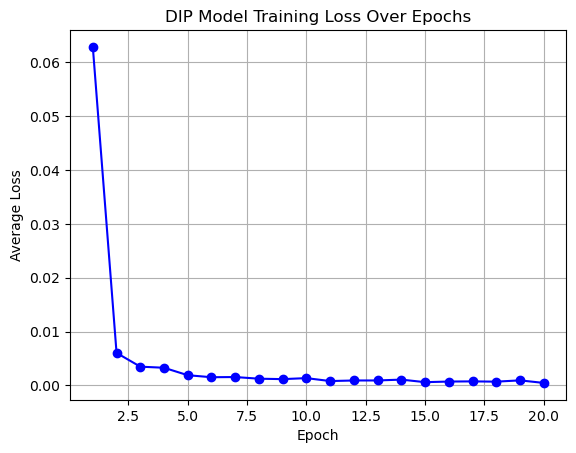

In [21]:
plt.plot(range(1, num_epochs_DIP+1), losses_DIP, marker='o', linestyle='-', color='b')
plt.title('DIP Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

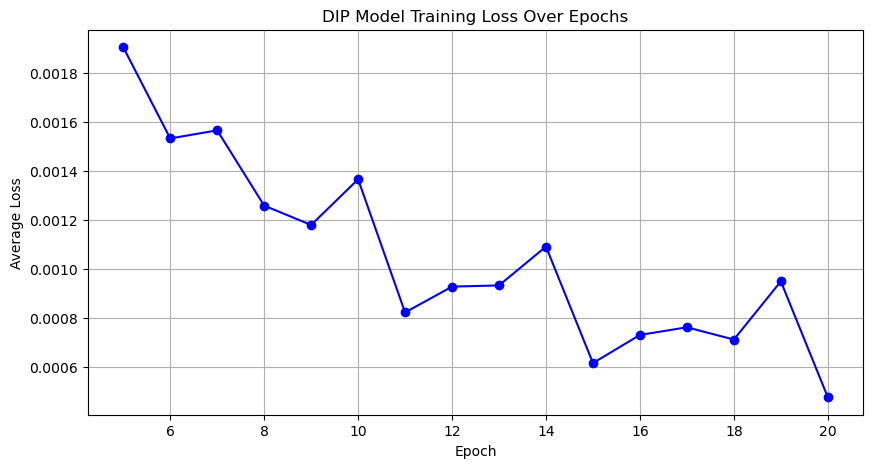

In [22]:
start_epoch = 5
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs_DIP + 1), losses_DIP[start_epoch - 1:], marker='o', linestyle='-', color='b')
plt.title('DIP Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

#### DDPM loss plot

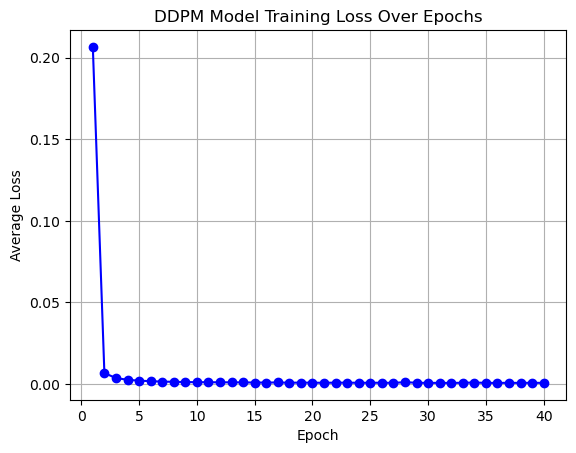

In [23]:
plt.plot(range(1, num_epochs_DDPM+1), losses_DDPM, marker='o', linestyle='-', color='b')
plt.title('DDPM Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

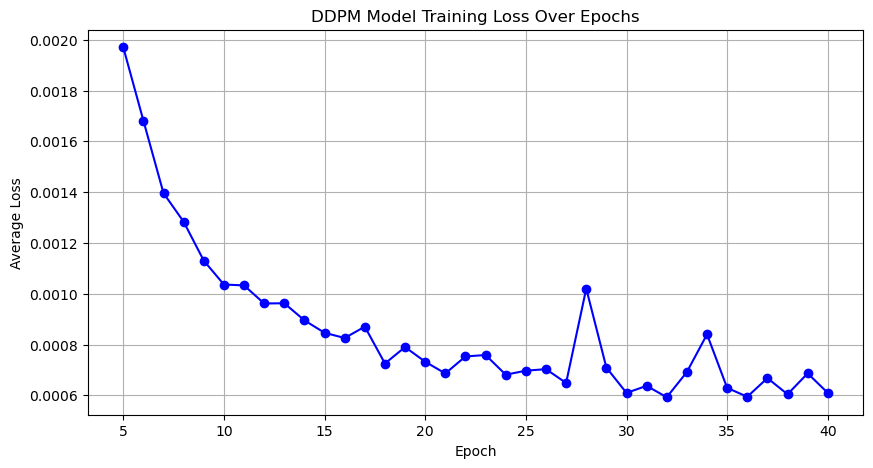

In [24]:
start_epoch = 5
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs_DDPM + 1), losses_DDPM[start_epoch - 1:], marker='o', linestyle='-', color='b')
plt.title('DDPM Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

### F. Evaluation

Image 1 - PSNR: 30.7499, SSIM: 0.9710, MSE: 0.0008, MAE: 0.0228, Delta E: 4.0087


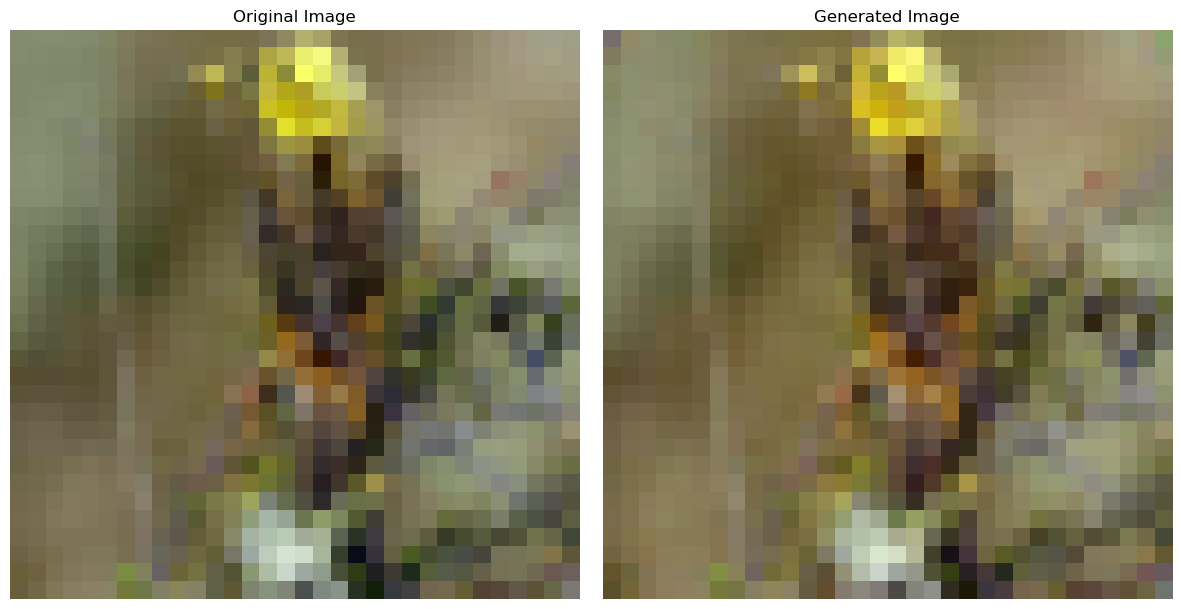

Image 2 - PSNR: 30.9817, SSIM: 0.9847, MSE: 0.0008, MAE: 0.0233, Delta E: 3.2210


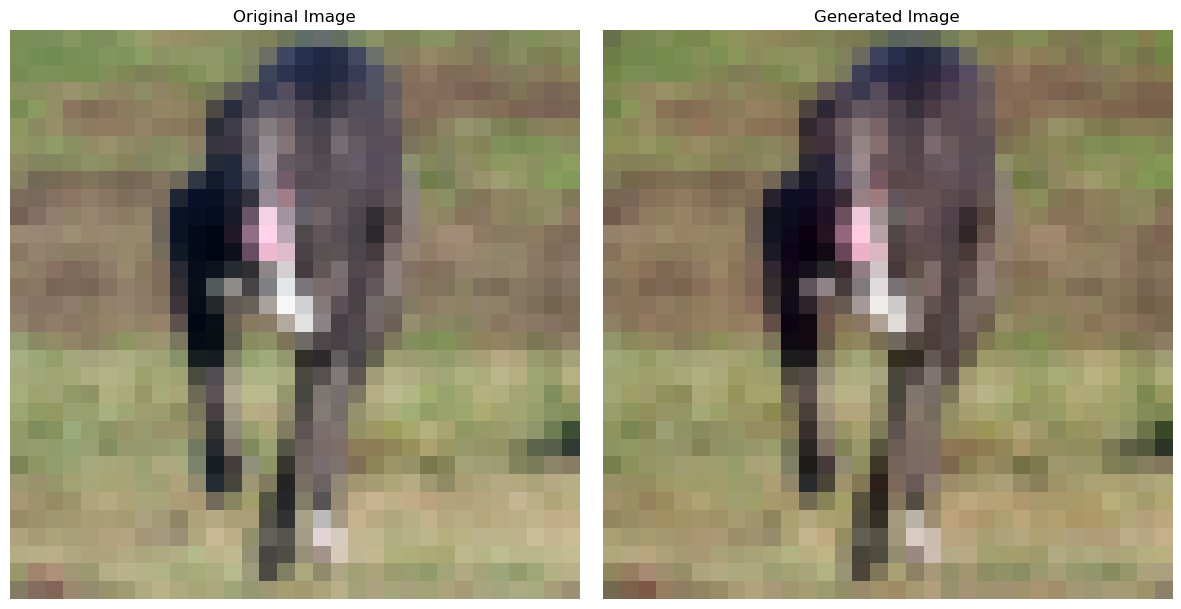

Image 3 - PSNR: 31.5878, SSIM: 0.9845, MSE: 0.0007, MAE: 0.0214, Delta E: 2.5856


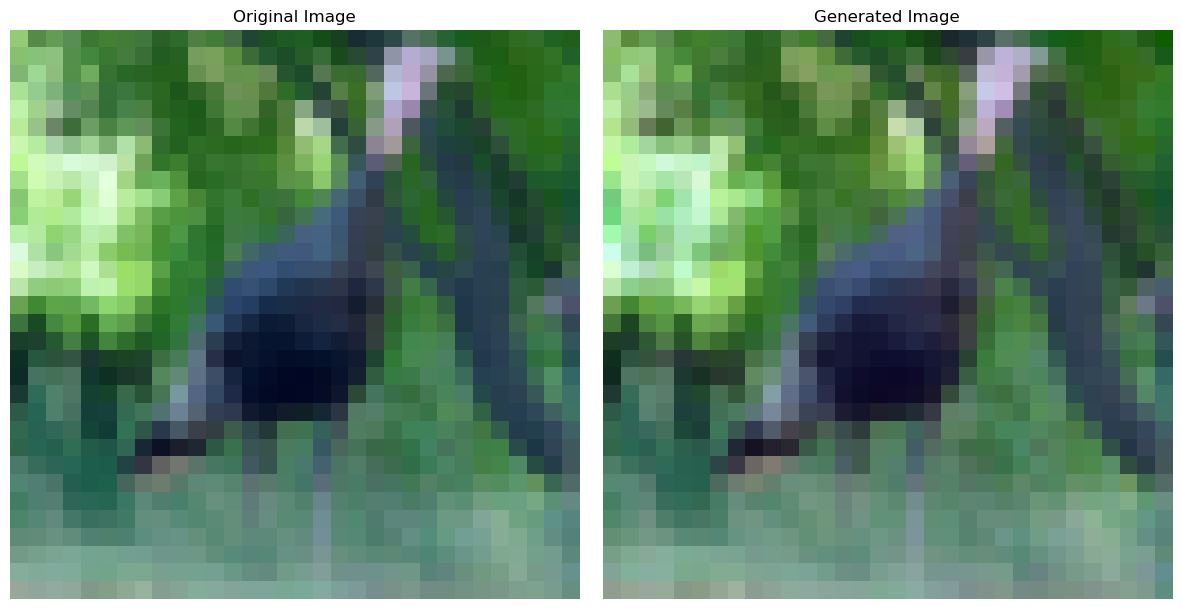

Image 4 - PSNR: 26.6016, SSIM: 0.9175, MSE: 0.0022, MAE: 0.0416, Delta E: 5.1713


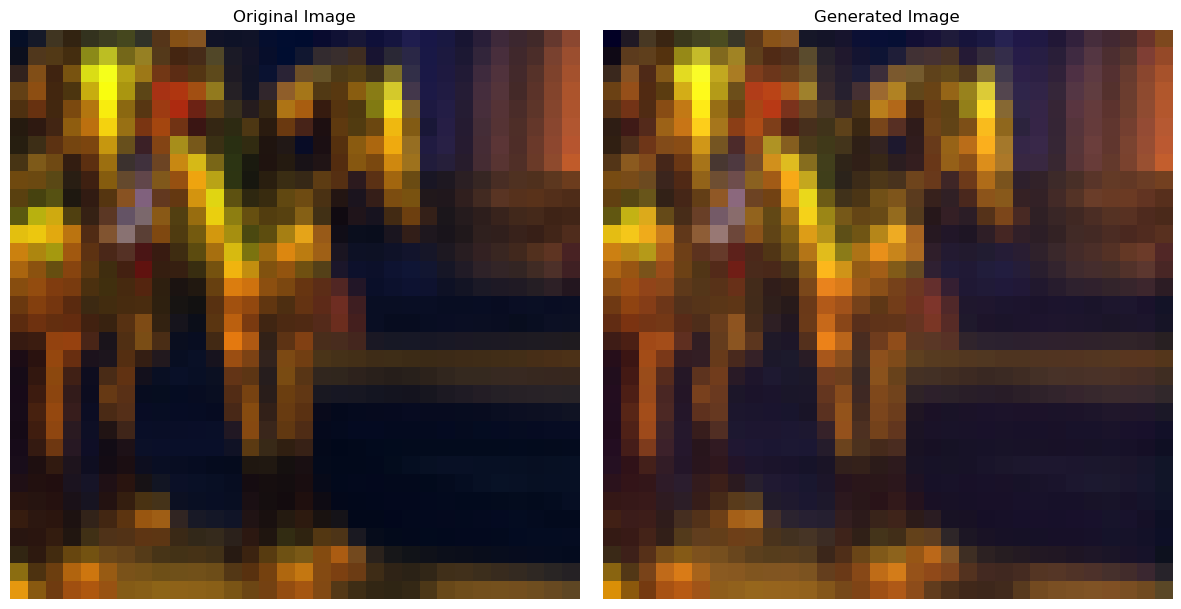

Image 5 - PSNR: 26.8675, SSIM: 0.9798, MSE: 0.0021, MAE: 0.0359, Delta E: 4.1531


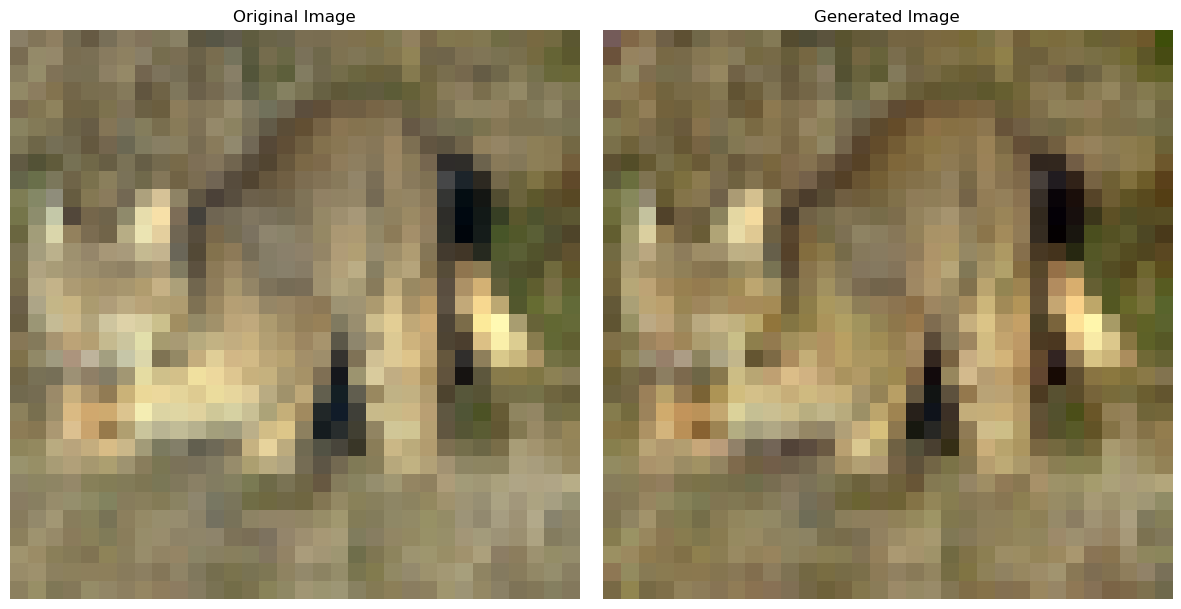

|    |   Image |    PSNR |     SSIM |         MSE |       MAE |   Delta E |
|---:|--------:|--------:|---------:|------------:|----------:|----------:|
|  0 |       1 | 30.7499 | 0.970973 | 0.000841421 | 0.0228    |   4.00871 |
|  1 |       2 | 30.9817 | 0.984668 | 0.000797682 | 0.023292  |   3.22095 |
|  2 |       3 | 31.5878 | 0.984511 | 0.000693773 | 0.0214486 |   2.58559 |
|  3 |       4 | 26.6016 | 0.917525 | 0.00218698  | 0.0416067 |   5.17127 |
|  4 |       5 | 26.8675 | 0.979828 | 0.00205708  | 0.0358885 |   4.15306 |


Average PSNR: 29.3577
Average SSIM: 0.9675
Average MSE: 0.0013
Average MAE: 0.0290
Average Delta E: 3.8279


In [25]:
num_images = 5
psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []
results = []

def display_images(original_img, generated_img):
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(121)
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2 = plt.subplot(122)
    ax2.imshow(generated_img)
    ax2.set_title('Generated Image')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(num_images):
    test_image, _ = training_set[i]
    restored_image = restored_image_func(DDPM_model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    original_image = test_image.cpu().permute(1, 2, 0).numpy()
    generated_image = restored_image.cpu().permute(1, 2, 0).numpy()

    psnr_value = psnr(original_image, generated_image, data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(original_image, generated_image, multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(original_image, generated_image)
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(original_image)
    restored_image_lab = rgb2lab(generated_image)
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

    print(f"Image {i+1} - PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, MSE: {mse_value:.4f}, MAE: {mae_value:.4f}, Delta E: {deltaE_value:.4f}")

    display_images(original_image, generated_image)
    results.append({
        "Image": i + 1,
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "MSE": mse_value,
        "MAE": mae_value,
        "Delta E": deltaE_value
    })

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

df = pd.DataFrame(results)

print(df.to_markdown())
print("\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")

## Comparison: DDPM Only vs. DDPM with DIP-Based Initial Prior

#### Convergence Speed

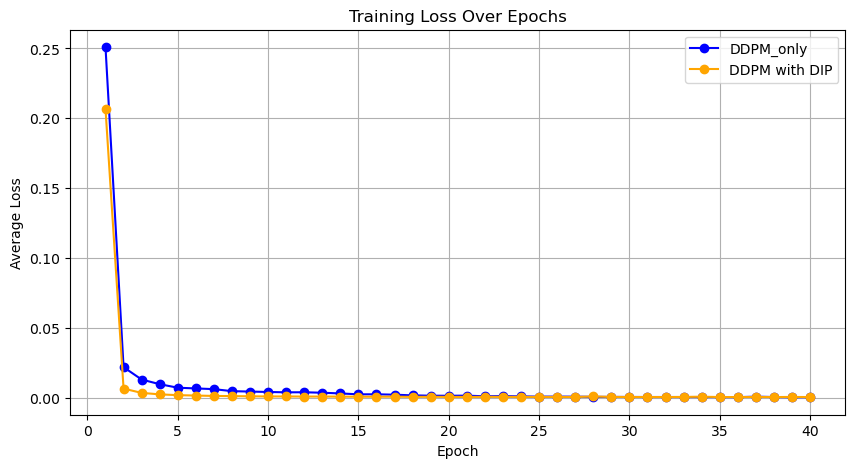

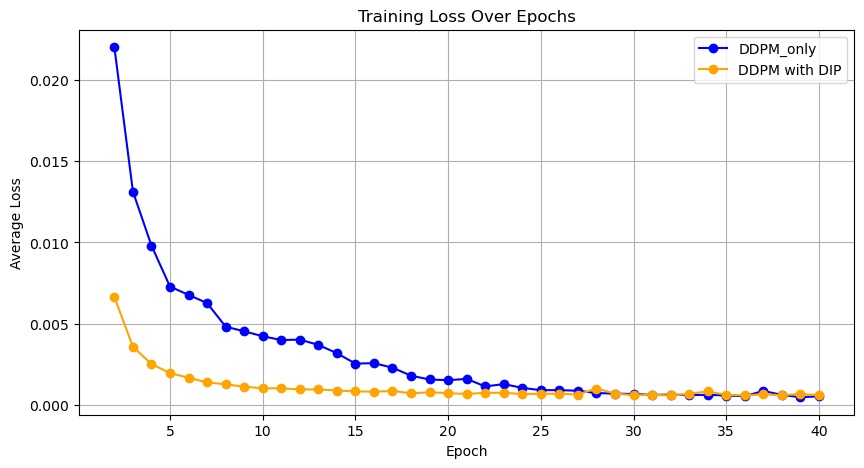

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs_DDPM+1), losses[0:num_epochs_DDPM], marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs_DDPM+1), losses_DDPM, marker='o', linestyle='-', color='orange')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend( ["DDPM_only", "DDPM with DIP"])
plt.show()

start_epoch = 2
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs_DDPM + 1), losses[start_epoch - 1:num_epochs_DDPM], marker='o', linestyle='-', color='b')
plt.plot(range(start_epoch, num_epochs_DDPM + 1), losses_DDPM[start_epoch - 1:], marker='o', linestyle='-', color='orange')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend( ["DDPM_only", "DDPM with DIP"])
plt.show()

#### Generated Picture Quality

In [30]:
psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []

for i in range(len(training_set)):
    DDPM_model.eval()
    test_image, _ = training_set[i]
    restored_image = restored_image_func(DDPM_model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    original_image = test_image.cpu().permute(1, 2, 0).numpy()
    generated_image = restored_image.cpu().permute(1, 2, 0).numpy()

    psnr_value = psnr(original_image, generated_image, data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(original_image, generated_image, multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(original_image, generated_image)
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(original_image)
    restored_image_lab = rgb2lab(generated_image)
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

print("\n")
print(f"=========================DDPM with DIP-base initial prior=========================\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")

psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []

for i in range(len(training_set)):
    model.eval()
    test_image, _ = training_set[i]
    restored_image = restored_image_func(model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    original_image = test_image.cpu().permute(1, 2, 0).numpy()
    generated_image = restored_image.cpu().permute(1, 2, 0).numpy()

    psnr_value = psnr(original_image, generated_image, data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(original_image, generated_image, multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(original_image, generated_image)
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(original_image)
    restored_image_lab = rgb2lab(generated_image)
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

print("\n")
print(f"=====================================DDPM_only====================================\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")



=========================DDPM with DIP-base initial prior=========================

Average PSNR: 27.0558
Average SSIM: 0.9122
Average MSE: 0.0030
Average MAE: 0.0394
Average Delta E: 5.6520


=====================================DDPM_only====================================

Average PSNR: 27.6635
Average SSIM: 0.9020
Average MSE: 0.0044
Average MAE: 0.0413
Average Delta E: 6.9387
